# Import

In [2]:
import sys

sys.path.append(".")
sys.path.append("..")

import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from importlib.machinery import SourceFileLoader


DATA_PATH = '../data/preprocessed_data.csv'
CONFIG_FILE = '../configs/predictor_cfgs.py'
CONFIG = SourceFileLoader("config", CONFIG_FILE).load_module()


sns.set_style("whitegrid", {'grid.linestyle': '--'})

# Classe distribution

In [3]:
# Split data
df = pd.read_csv(DATA_PATH)
df_train, df_val = train_test_split(
    df,
    train_size=CONFIG.train_size,
    test_size=CONFIG.test_size,
    random_state=CONFIG.split_seed
)
DF_TRAIN = df_train
DF_VAL = df_val

In [4]:
# Calculating percentage case/control distribution
train_case_count = df_train[CONFIG.phenotypes].sum()
val_case_count = df_val[CONFIG.phenotypes].sum()
train_control_count= len(df_train) - train_case_count
val_control_count = len(df_val) - val_case_count

train_case_percentage = (train_case_count / df_train.shape[0]) * 100
train_control_percentage = (train_control_count / df_train.shape[0]) * 100

val_case_percentage = (val_case_count / df_val.shape[0]) * 100
val_control_percentage = (val_control_count / df_val.shape[0]) * 100

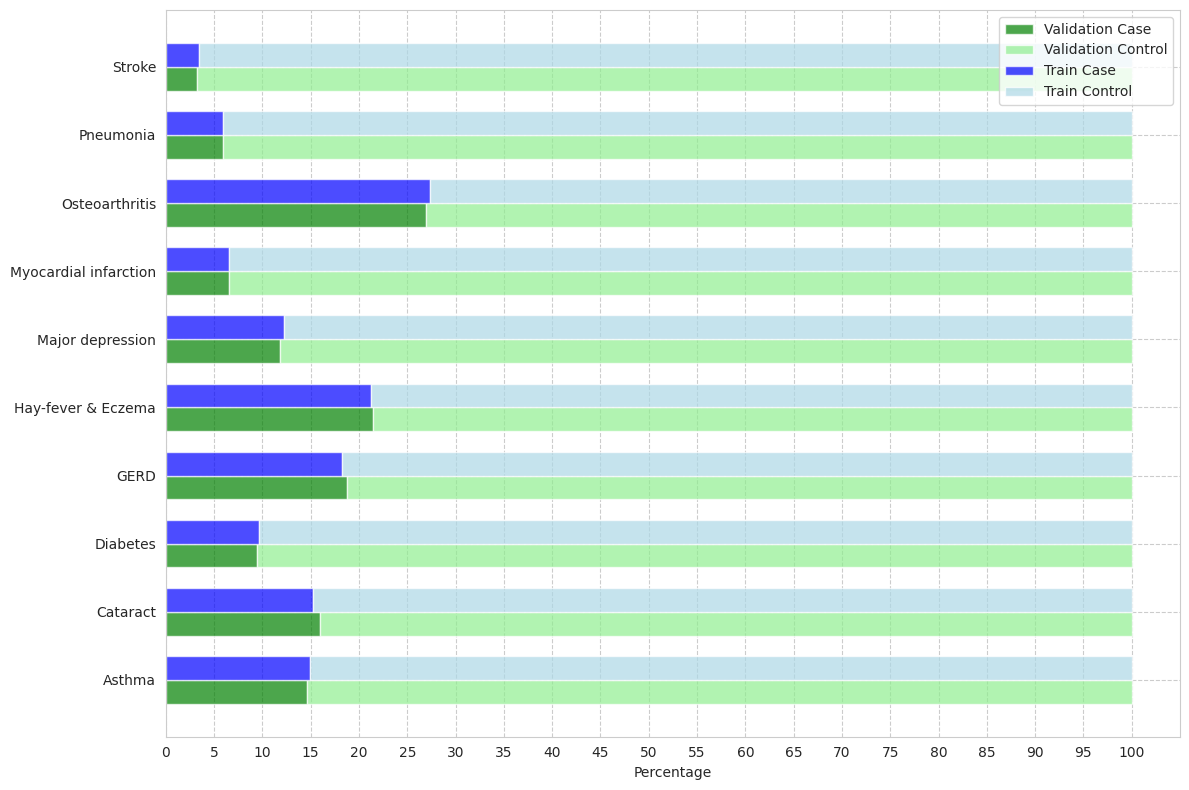

In [5]:
# Creating the bar plot with train and validation datasets side by side, with percentage and disease on y-axis
fig, ax = plt.subplots(figsize=(12, 8))

width = 0.35  # Width of the bars
indices = range(len(train_case_percentage))

# Plotting the case/control distribution for the validation dataset
val_bars_case = ax.barh([i - width/2 for i in indices], val_case_percentage, width, label='Validation Case', color='green', alpha=0.7)
val_bars_control = ax.barh([i - width/2 for i in indices], val_control_percentage, width, left=val_case_percentage, label='Validation Control', color='lightgreen', alpha=0.7)

# Plotting the case/control distribution for the train dataset
train_bars_case = ax.barh([i + width/2 for i in indices], train_case_percentage, width, label='Train Case', color='blue', alpha=0.7)
train_bars_control = ax.barh([i + width/2 for i in indices], train_control_percentage, width, left=train_case_percentage, label='Train Control', color='lightblue', alpha=0.7)

# Adding labels and title
ax.set_xlabel('Percentage')
# ax.set_title('Case/Control Distribution for Train and Validation Datasets (Percentage)')
ax.set_yticks(indices)
ax.set_yticklabels(train_case_percentage.index)

# Adding the legend
ax.legend()

# Setting xticks to every 5 percentage
ax.set_xticks(range(0, 101, 5))

plt.tight_layout()
plt.show()

# Risk scores plots

In [6]:
def extract_info_from_path(risk_score_path):
    parts = risk_score_path.split(os.sep)
    model_name = parts[-2]
    phenotype = parts[-1].split('_')[1]
    if model_name not in ['LogReg', 'XGBoost']:
        feature_set = parts[-1].split('_')[2]
        num_shots = parts[-1].split('_')[-1].split('-')[0]
    else:
        feature_set = parts[-1].split('_')[2].split('.')[0]
        num_shots = None
    return model_name, feature_set, phenotype, num_shots

In [7]:
def plot_risk_scores(log_reg_scores_path, xgb_scores_path, llm_scores_path):
    with open(log_reg_scores_path, 'r') as f:
        log_reg_data = json.load(f)
        log_reg_true = log_reg_data["y_true"]
        log_reg_scores = log_reg_data["y_scores"]

    with open(xgb_scores_path, 'r') as f:
        xgb_data = json.load(f)
        xgb_true = xgb_data["y_true"]
        xgb_scores = xgb_data["y_scores"]

    with open(llm_scores_path, 'r') as f:
        llm_data = json.load(f)
        llm_true = llm_data["y_true"]
        llm_scores = llm_data["y_scores"]
        model_name, feature_set, phenotype, num_shots = extract_info_from_path(llm_scores_path)

    # Assert that true labels are the same for all models
    assert log_reg_true == xgb_true == llm_true, "True labels do not match across models."

    # Create a DataFrame
    data = {
        'Logistic Regression': log_reg_scores,
        'XGBoost': xgb_scores,
        'LLM': llm_scores,
        'True Label': llm_true
    }
    df = pd.DataFrame(data)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))

    # Scatter plot for Logistic Regression vs LLM
    ax1.scatter(df['Logistic Regression'], df['LLM'], color='green')  
    ax1.set_xlabel('Logistic Regression Scores')
    ax1.set_ylabel(f'{model_name} ({num_shots}-shot) Scores')
    ax1.set_title(f'LogReg vs. LLM risk scores ({phenotype}, {feature_set})')

    # Scatter plot for XGBoost vs LLM
    ax2.scatter(df['XGBoost'], df['LLM'], color='orange')
    ax2.set_xlabel('XGBoost Scores')
    ax2.set_title(f'XGBoost vs. LLM risk scores ({phenotype}, {feature_set})')
    
    plt.tight_layout()
    plt.show()

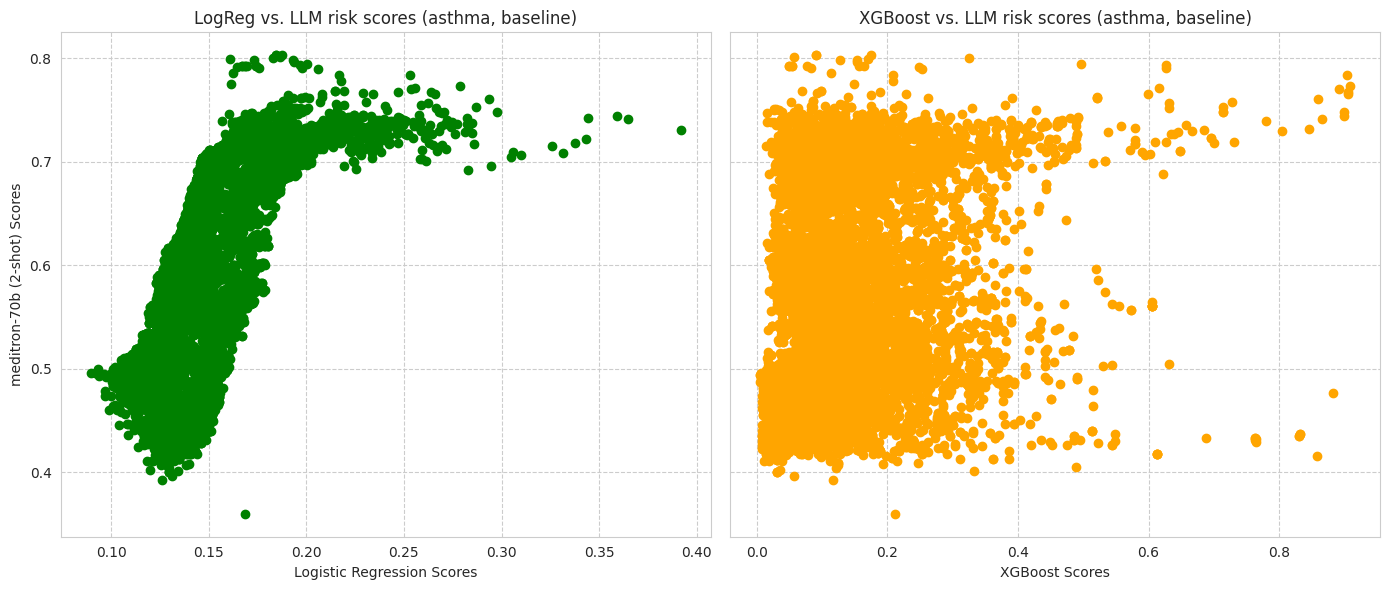

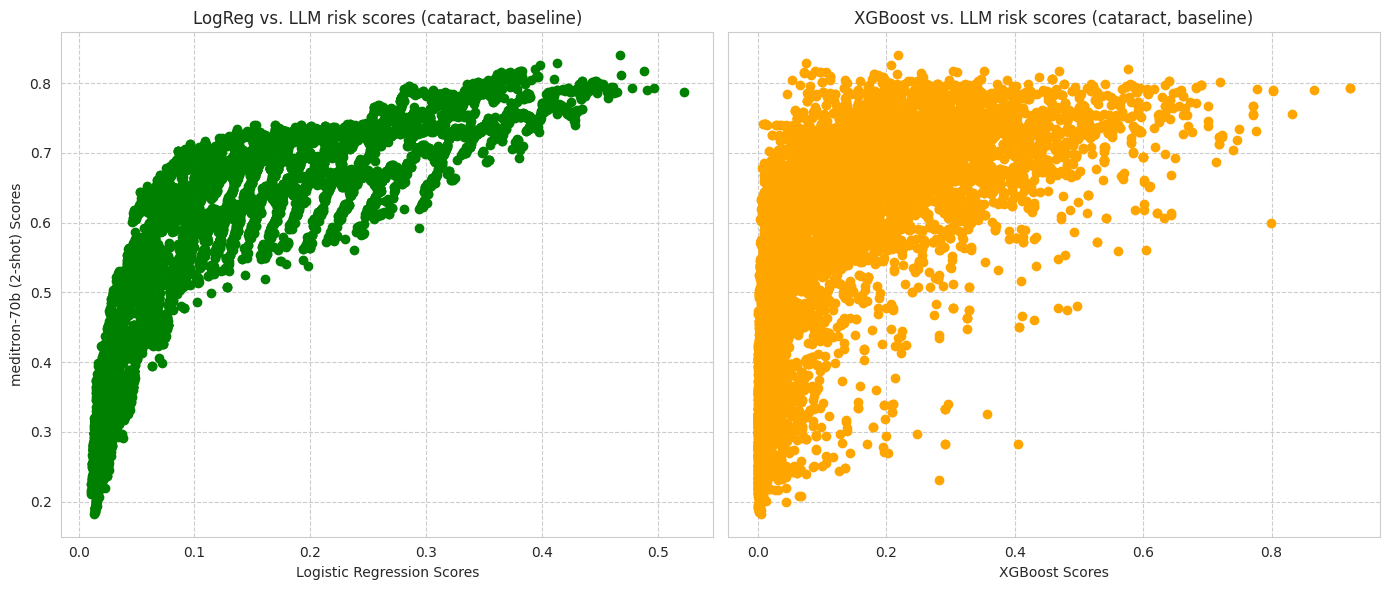

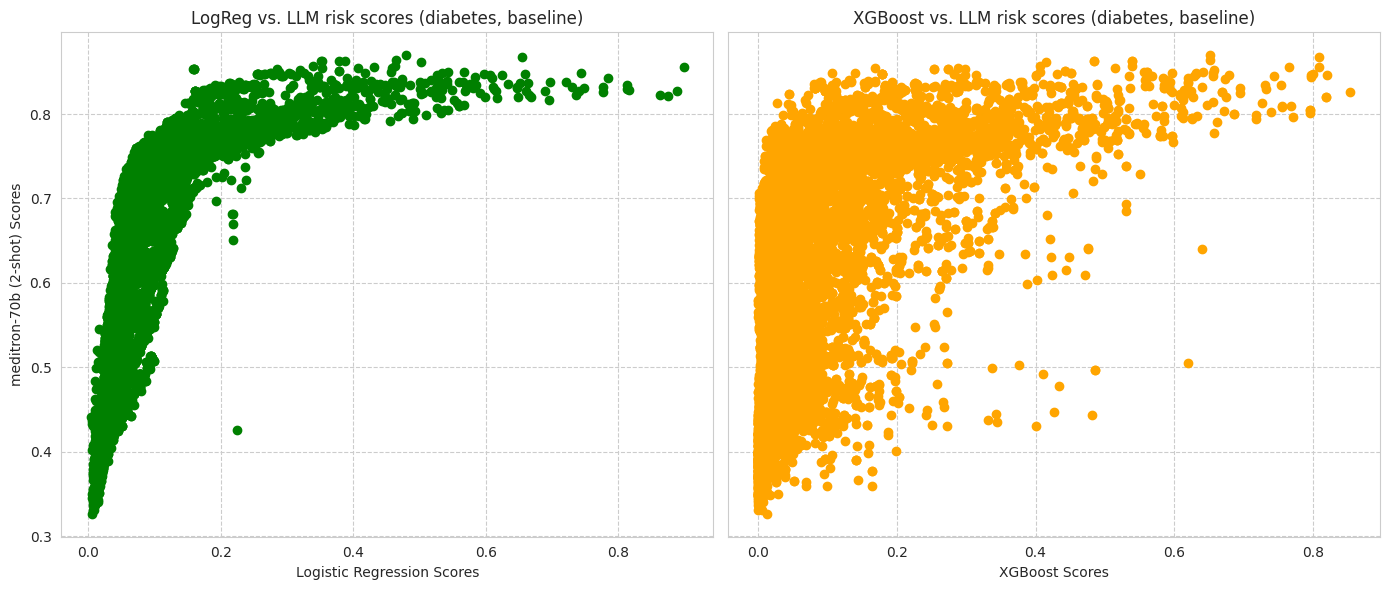

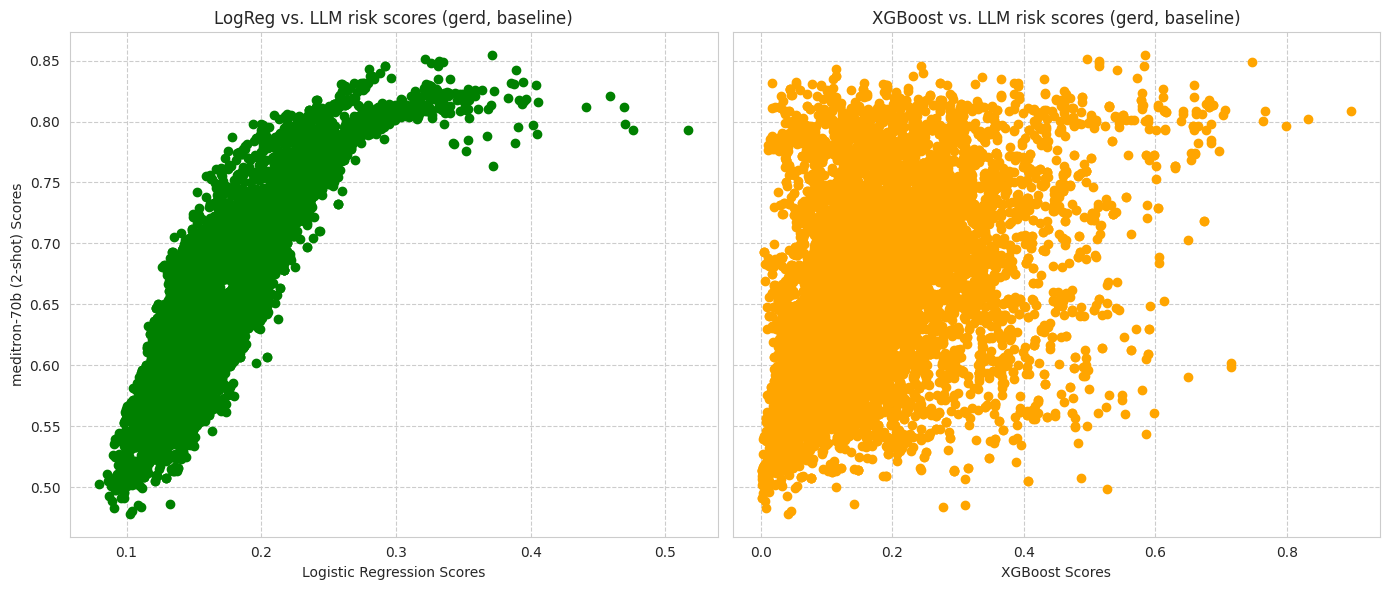

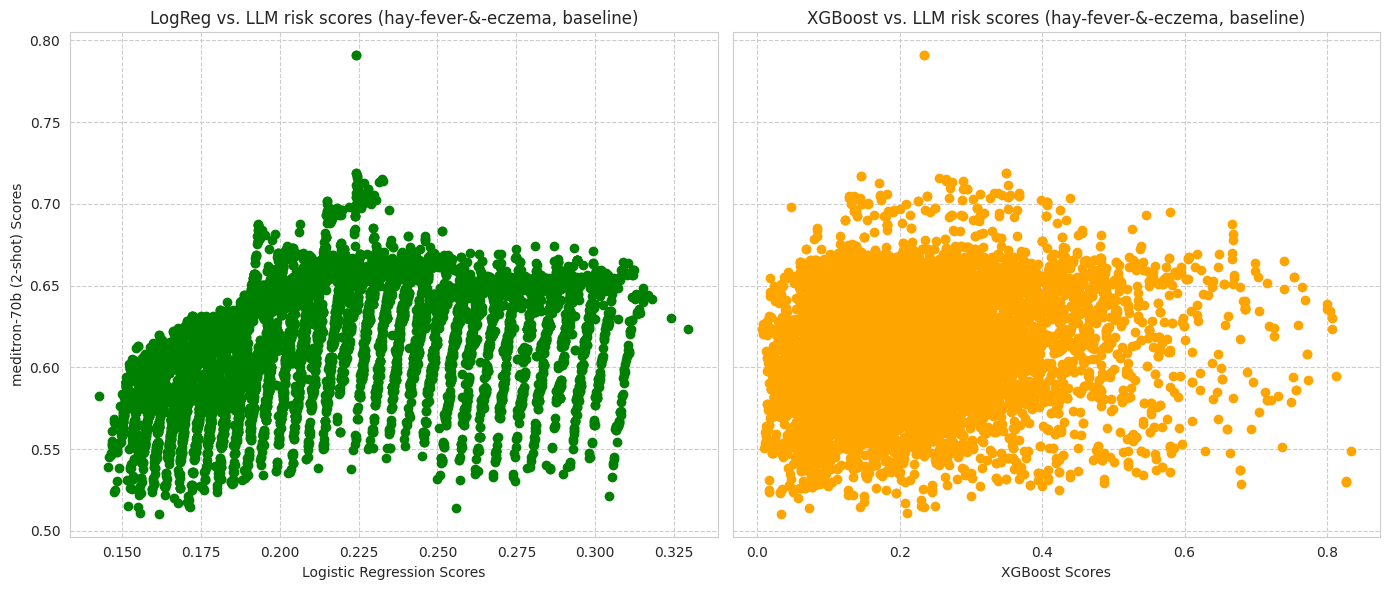

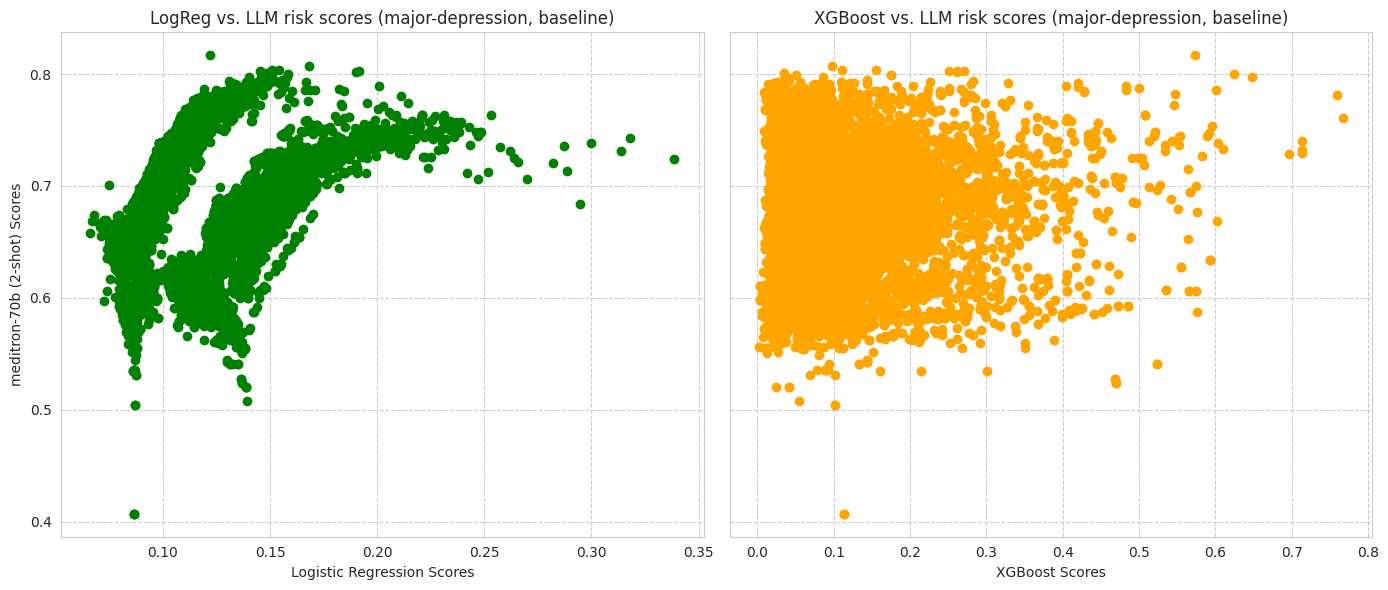

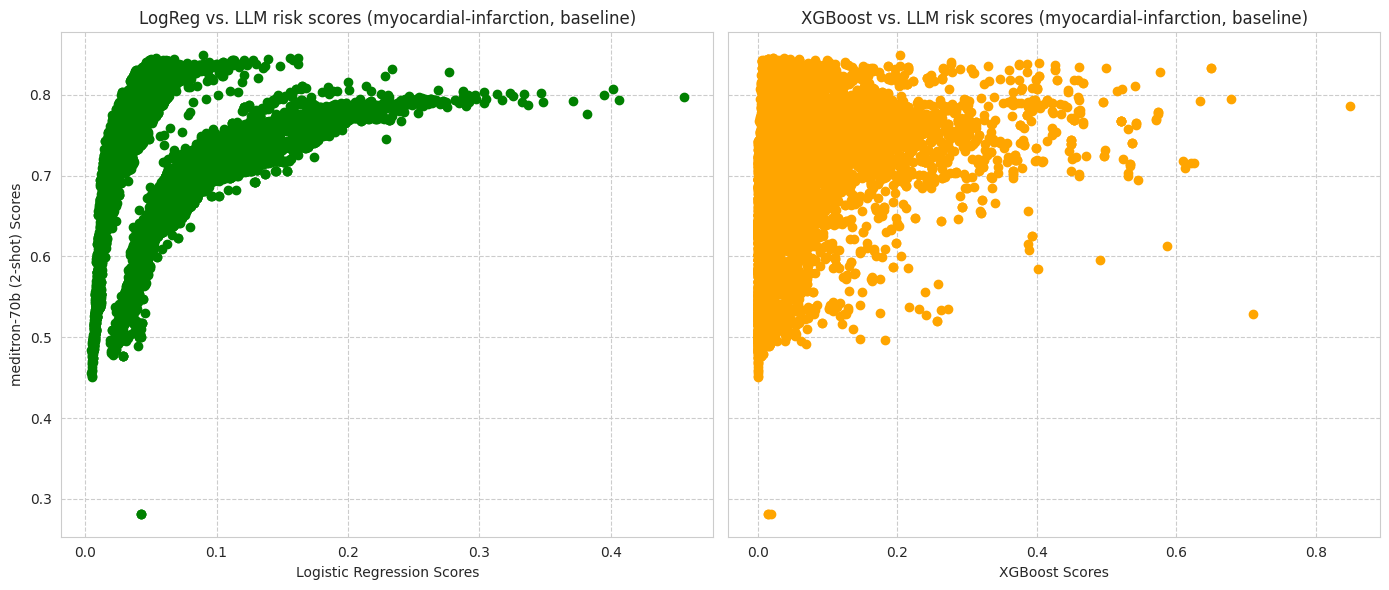

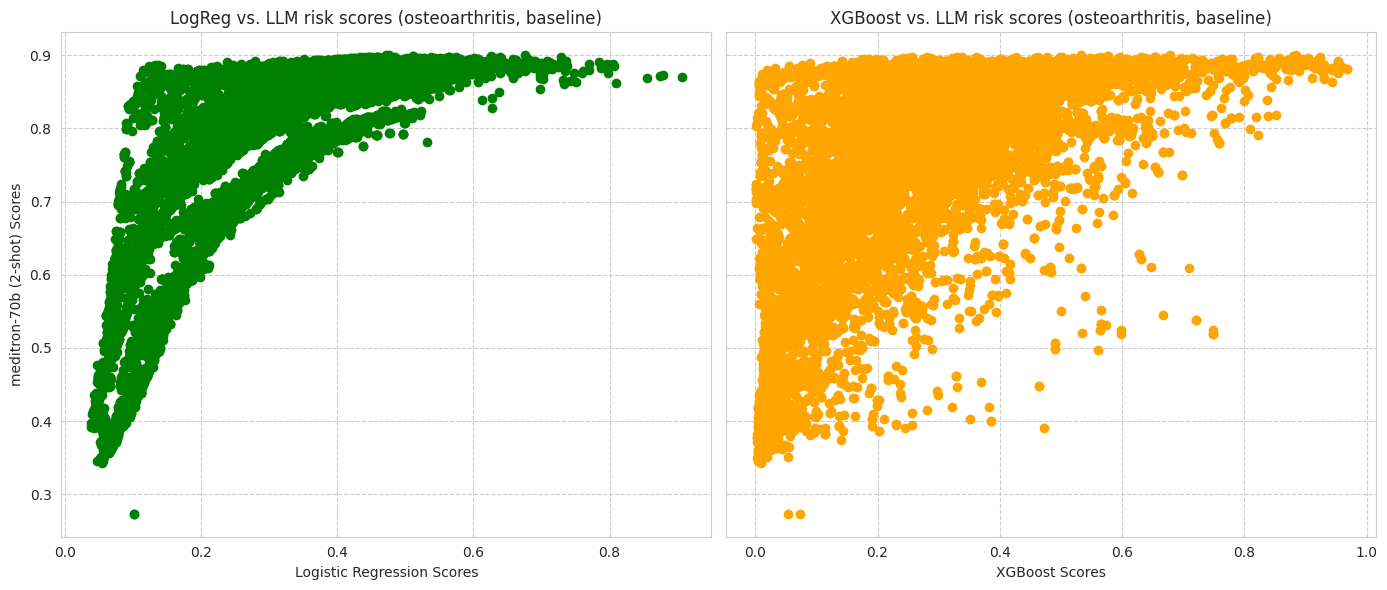

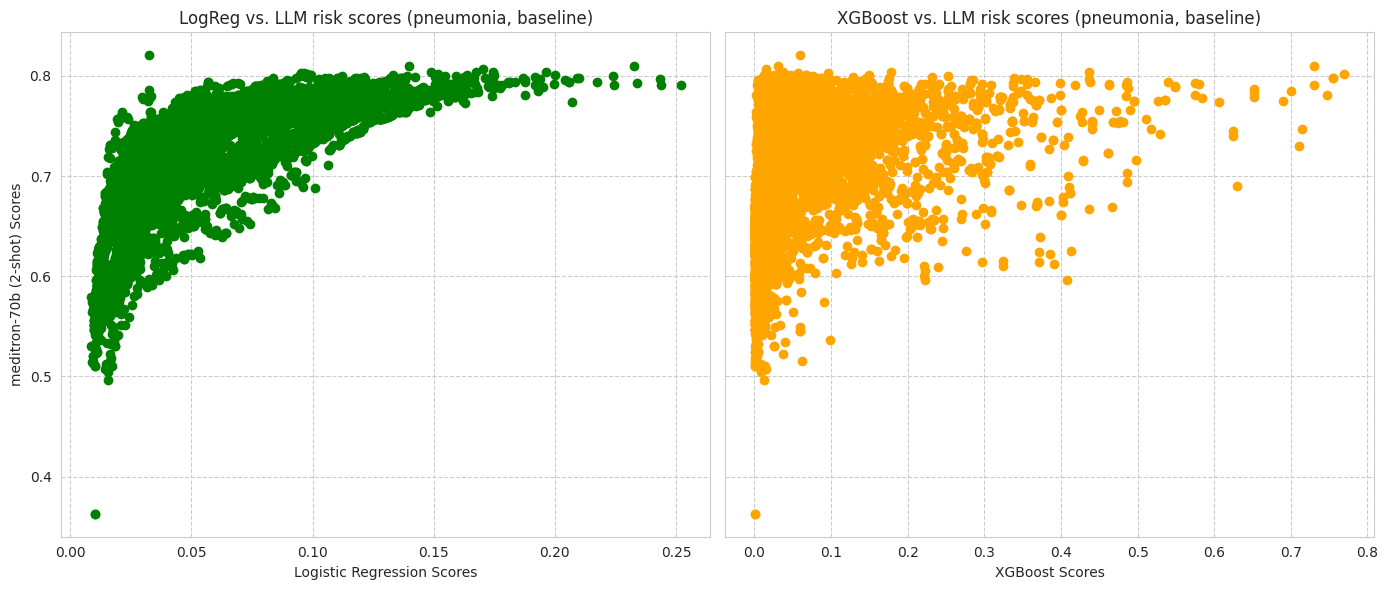

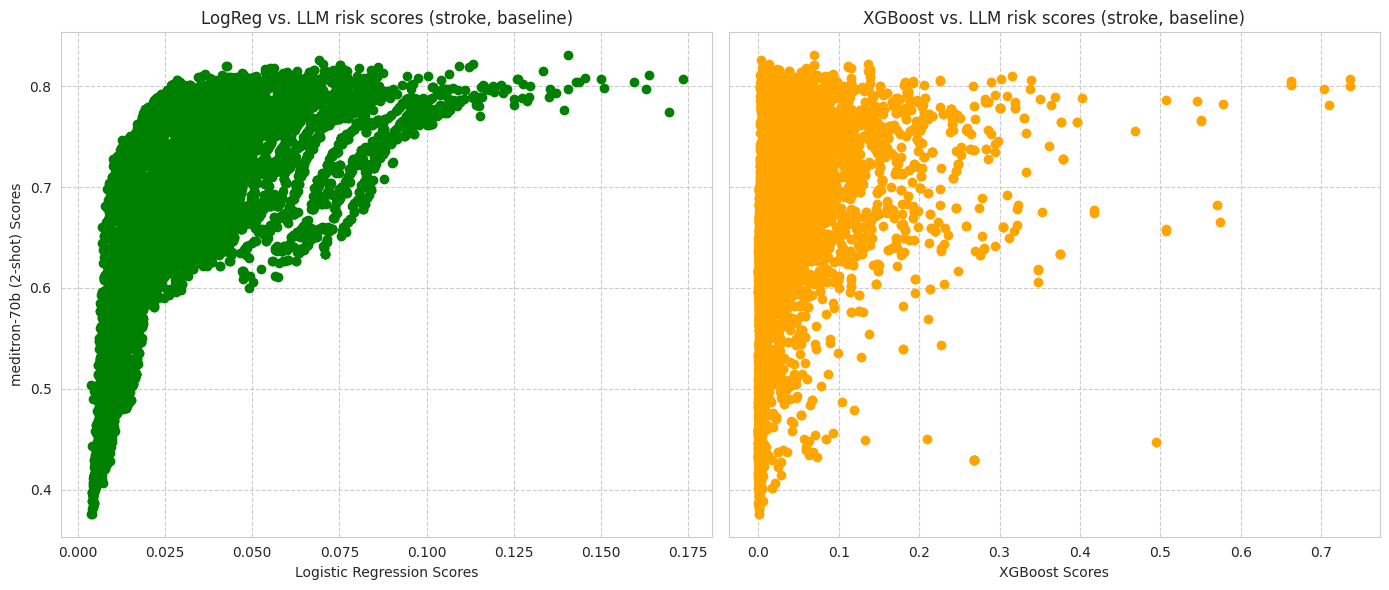

In [8]:
PHENOTYPES = [
    'asthma',
    'cataract',
    'diabetes',
    'gerd',
    'hay-fever-&-eczema',
    'major-depression',
    'myocardial-infarction',
    'osteoarthritis',
    'pneumonia',
    'stroke'
]
LLM_ID = 'epfl-llm/meditron-70b'
NB_SHOTS = 2
FEATURE_SET = 'baseline'

for phenotype in PHENOTYPES:
    log_reg_scores_path = f"../output/risk_scores/LogReg/rs_{phenotype}_{FEATURE_SET}.json"
    xgb_scores_path = f"../output/risk_scores/XGBoost/rs_{phenotype}_{FEATURE_SET}.json"
    llm_scores_path = f"../hf_datasets/LLM-Disease-Risk-Scores/{LLM_ID}/rs_{phenotype}_{FEATURE_SET}_float16_{NB_SHOTS}-shots.json"

    plot_risk_scores(log_reg_scores_path, xgb_scores_path, llm_scores_path)

# Age/BMI vs. Risk scores

In [9]:
def plot_age_bmi_vs_risk_score(risk_score_path, df):
    model_name, feature_set, phenotype, num_shots = extract_info_from_path(risk_score_path)
    
    # Load the risk scores from the JSON file
    with open(risk_score_path, 'r') as f:
        risk_data = json.load(f)
        eids = risk_data["eids"]
        risk_scores = risk_data["y_scores"]
    
    # Create a DataFrame for the risk scores
    df_risk = pd.DataFrame({'risk_score': risk_scores}, index=eids)
    
    # Ensure the DataFrame contains the required columns
    required_columns = ['eid', 'Age', 'BMI', 'Sex']
    if not all(column in df.columns for column in required_columns):
        raise ValueError(f"The DataFrame must contain the following columns: {', '.join(required_columns)}")
    
    # Set 'eid' as index
    df = df.set_index('eid')
    
    # Combine the risk scores with the age, BMI, and sex data
    df_combined = df_risk.join(df[['Age', 'BMI', 'Sex']]).dropna()

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Define colors for sexes
    colors = {'Male': 'blue', 'Female': 'red'}
    markers = {'Male': 'o', 'Female': 's'}
    
    # Age vs Risk Score
    for sex in df_combined['Sex'].unique():
        subset = df_combined[df_combined['Sex'] == sex]
        ax1.scatter(subset['Age'], subset['risk_score'], alpha=0.5, label=sex, c=colors[sex], marker=markers[sex])
    ax1.set_xlabel('Age')
    ax1.set_ylabel('Risk Score')
    if num_shots:
        ax1.set_title(f'Age vs. Risk Score ({phenotype}, {feature_set}, {model_name} {num_shots}-shot)')
    else:
        ax1.set_title(f'Age vs. Risk Score ({phenotype}, {feature_set}, {model_name})')
    ax1.legend(title='Sex')

    # BMI vs Risk Score
    for sex in df_combined['Sex'].unique():
        subset = df_combined[df_combined['Sex'] == sex]
        ax2.scatter(subset['BMI'], subset['risk_score'], alpha=0.5, label=sex, c=colors[sex], marker=markers[sex])
    ax2.set_xlabel('BMI')
    if num_shots:
        ax2.set_title(f'BMI vs. Risk Score ({phenotype}, {feature_set}, {model_name} {num_shots}-shot)')
    else:
        ax2.set_title(f'BMI vs. Risk Score ({phenotype}, {feature_set}, {model_name})')
    ax2.legend(title='Sex')

    plt.tight_layout()
    plt.show()

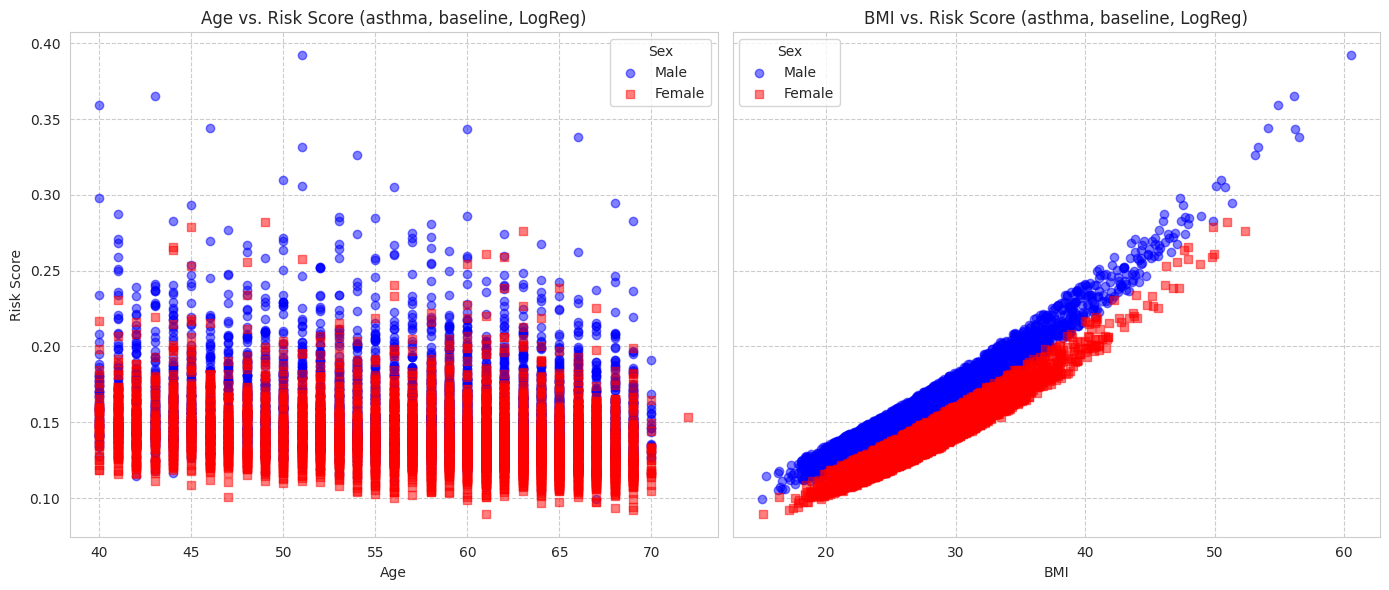

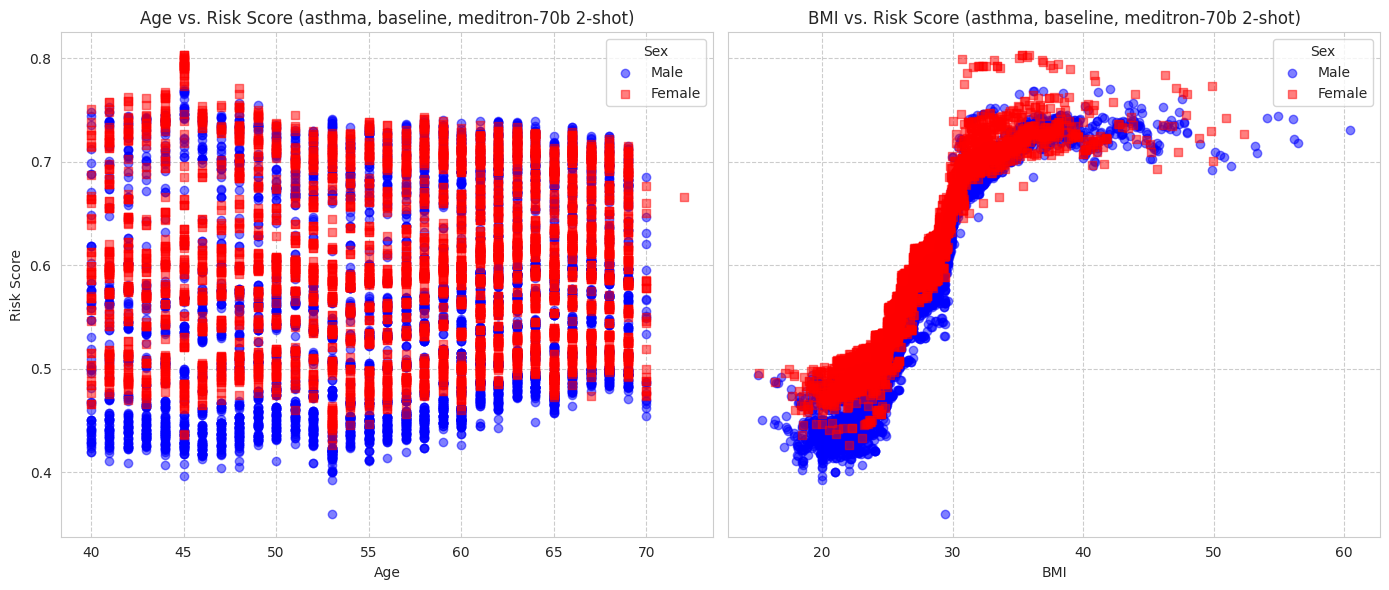

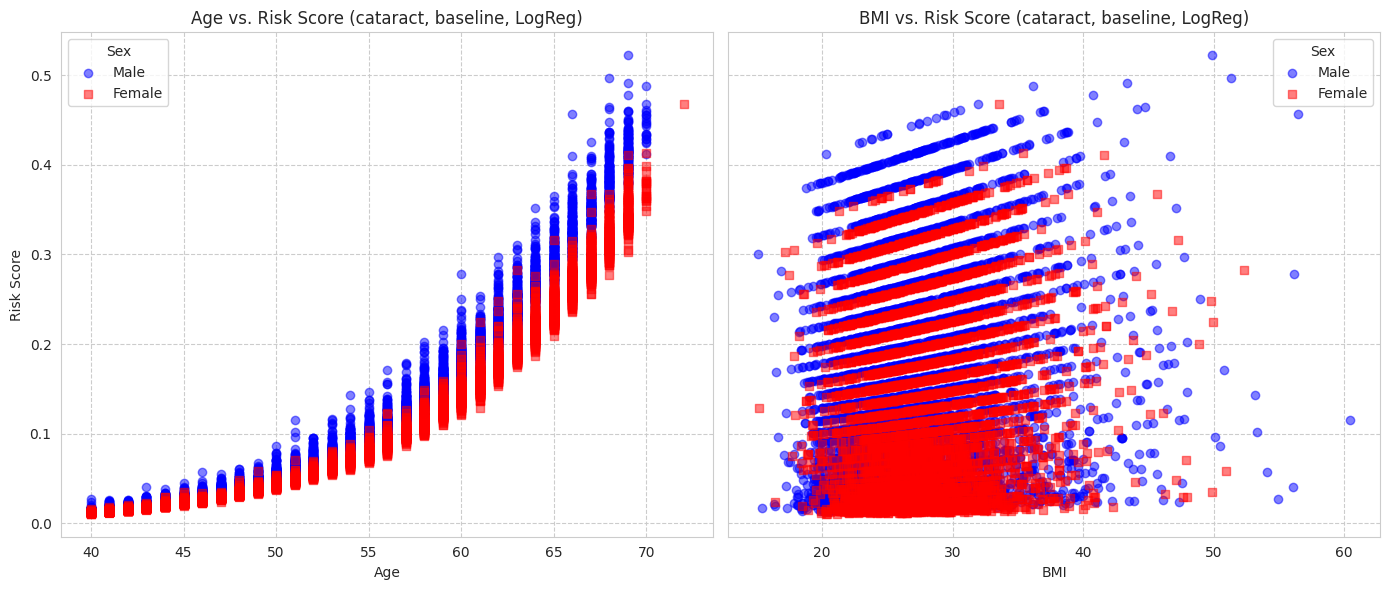

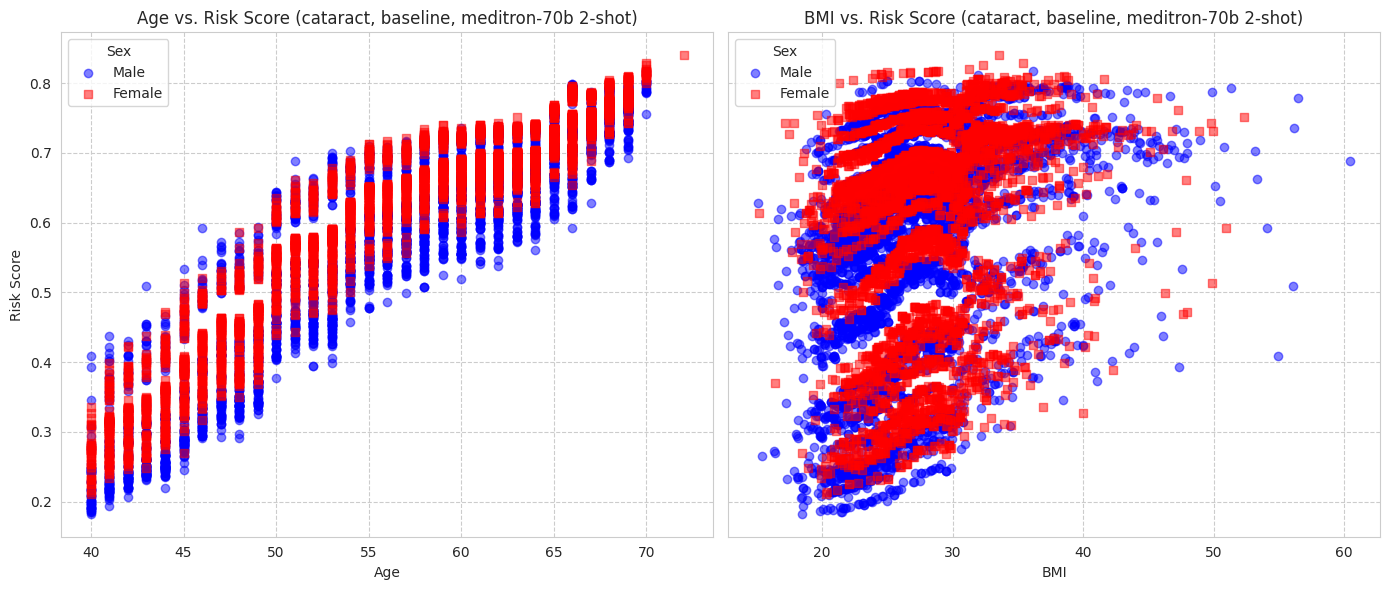

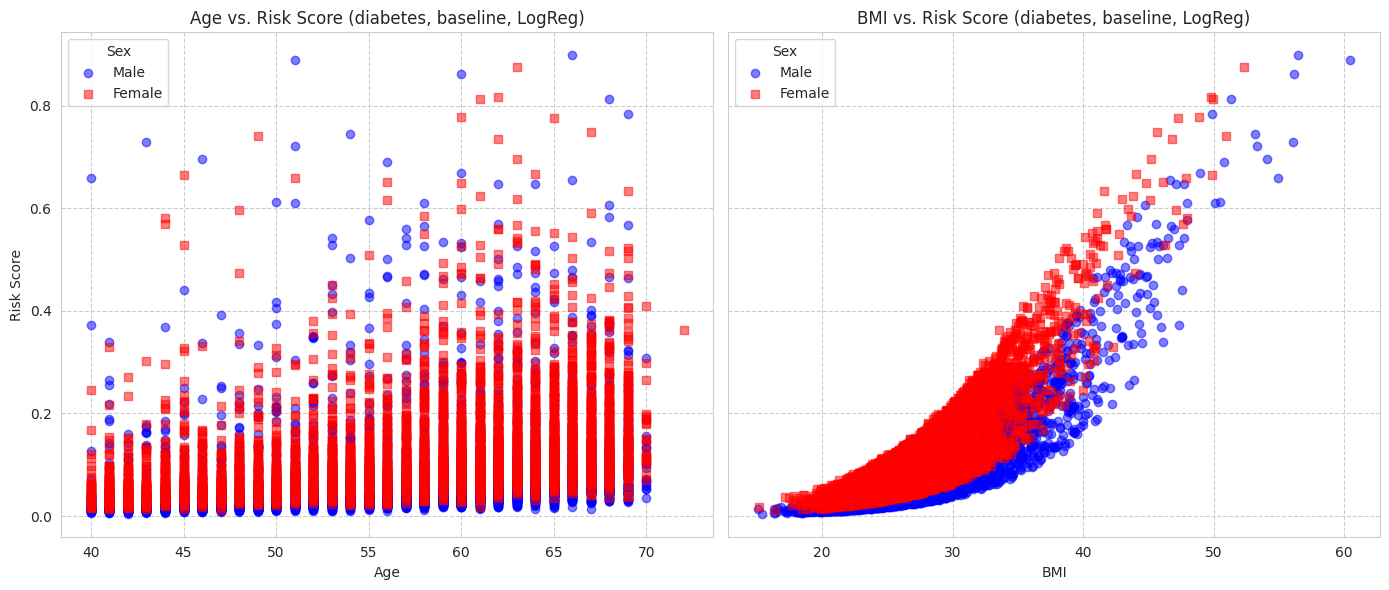

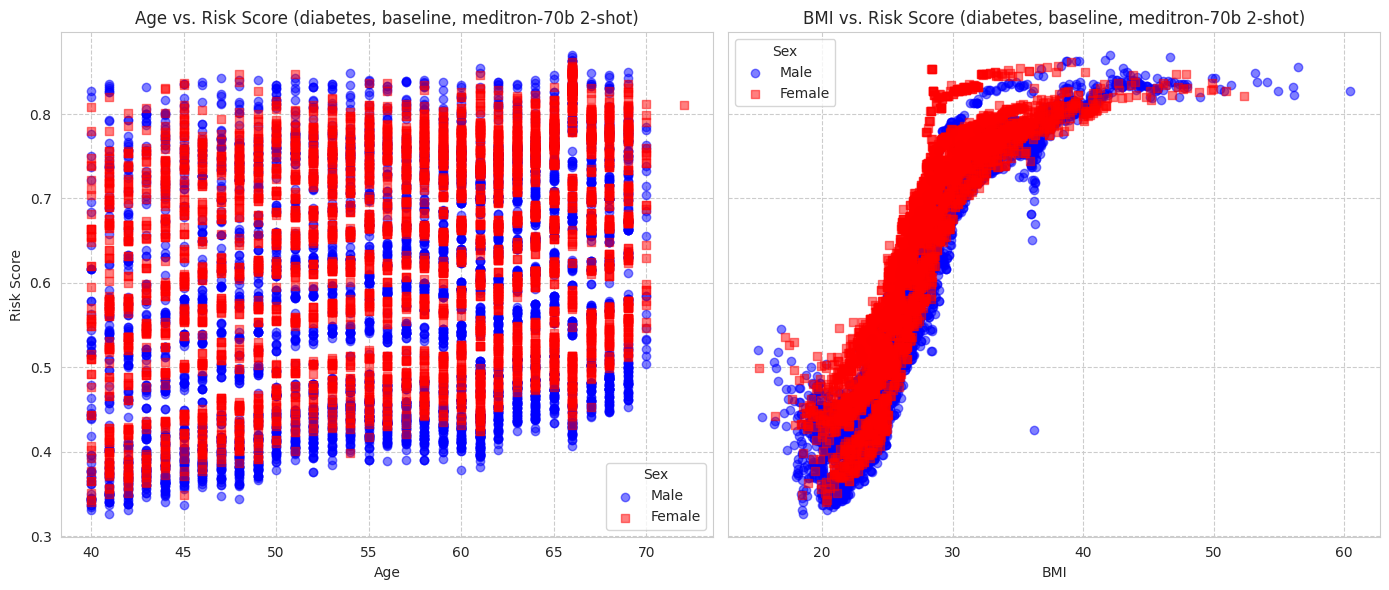

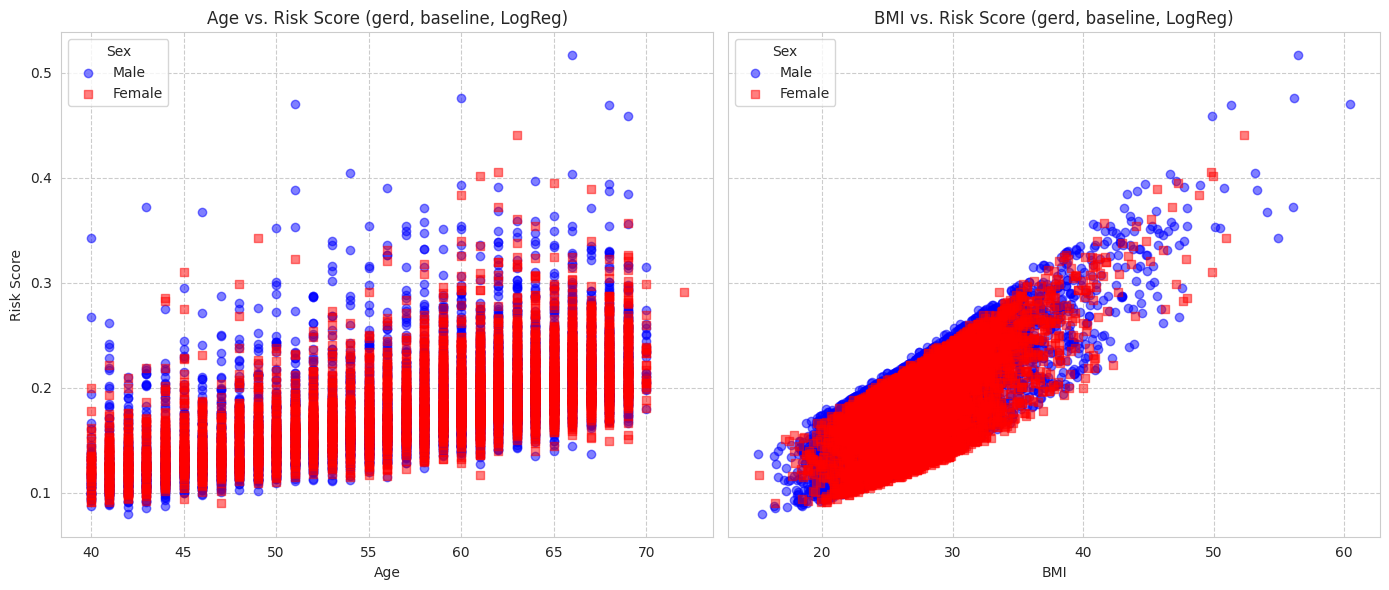

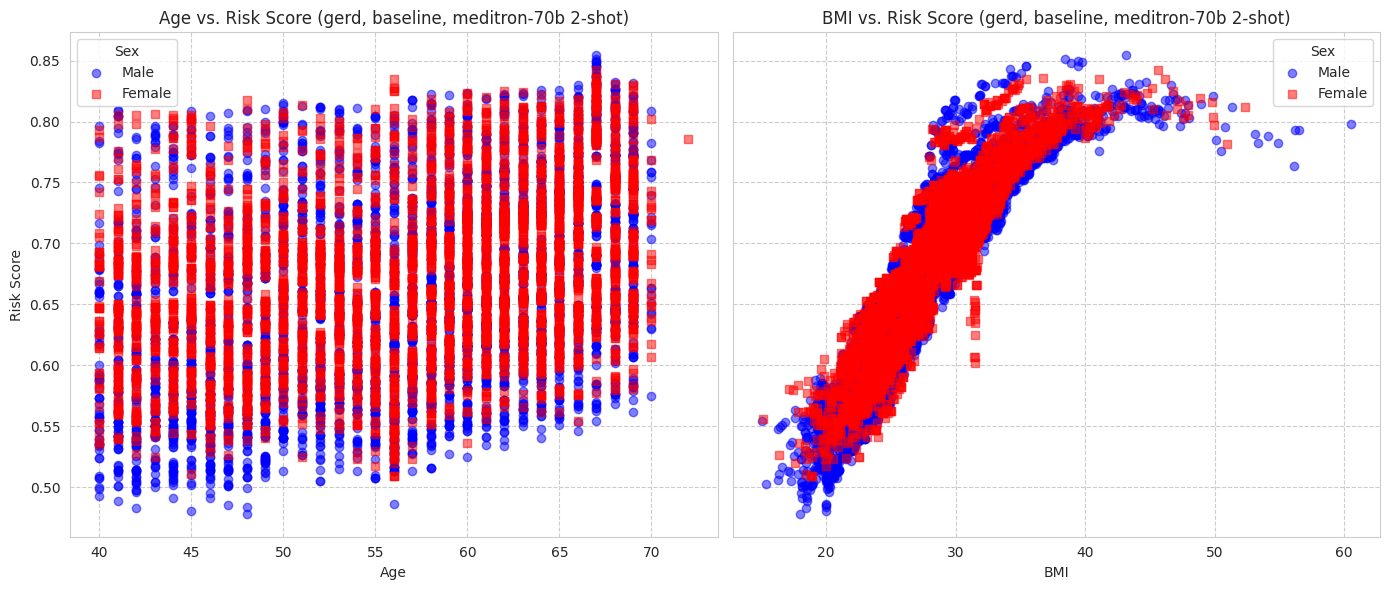

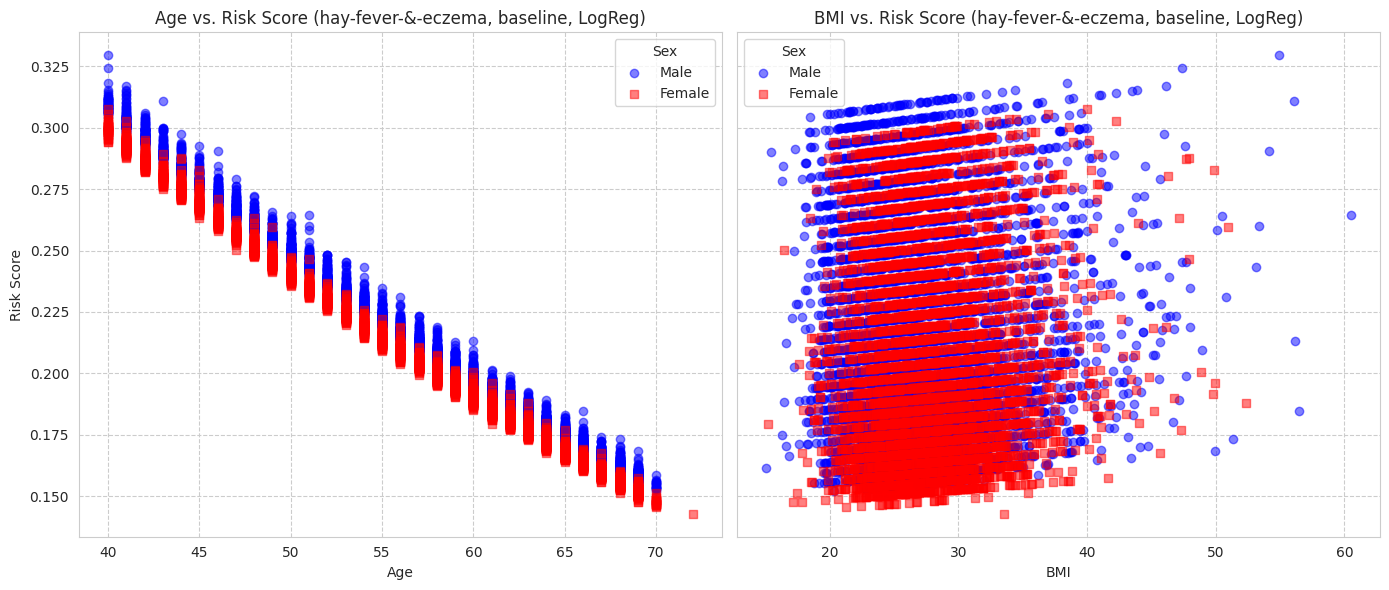

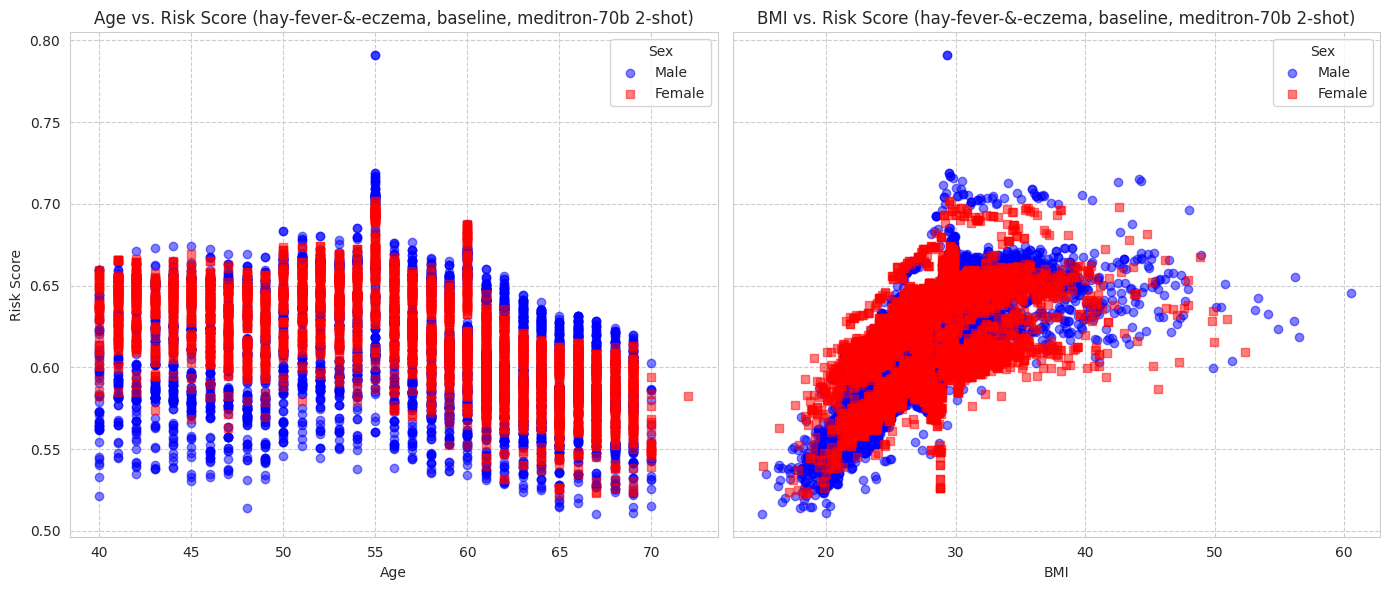

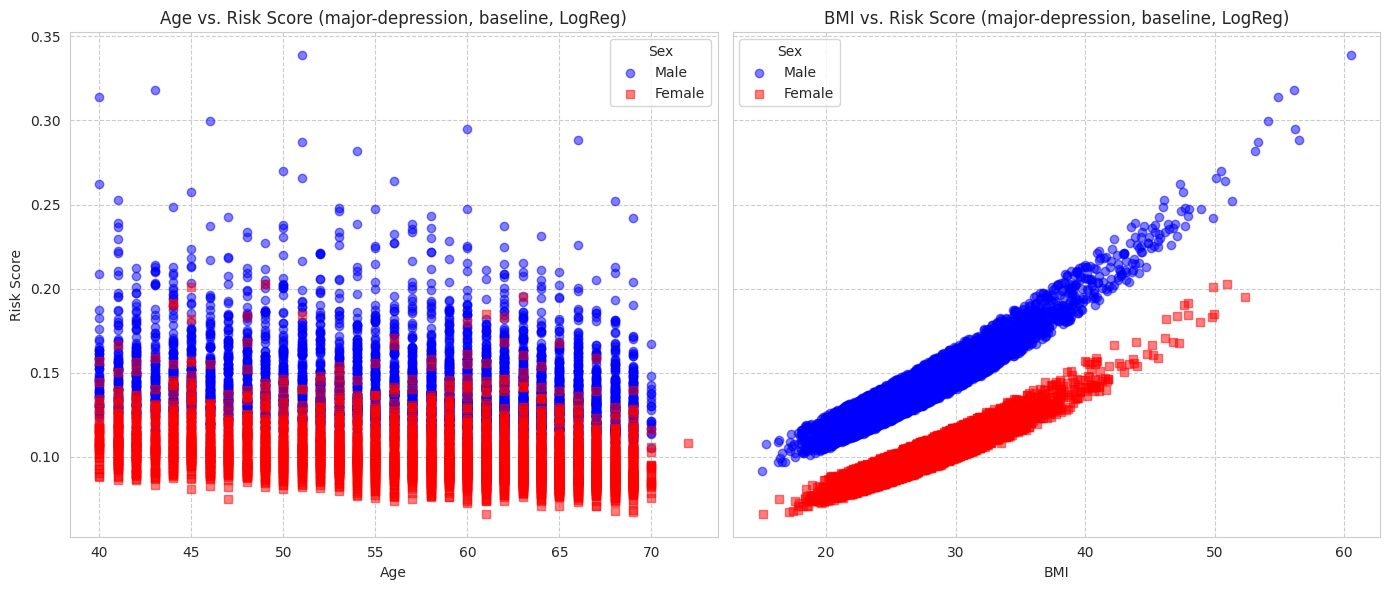

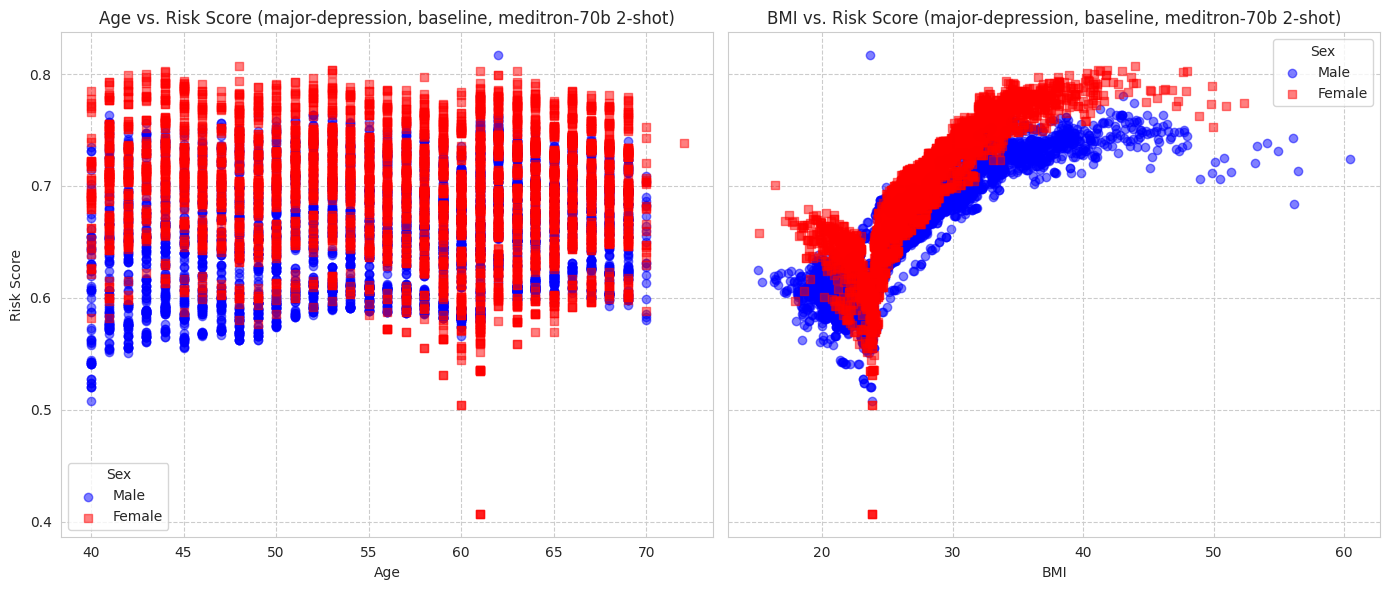

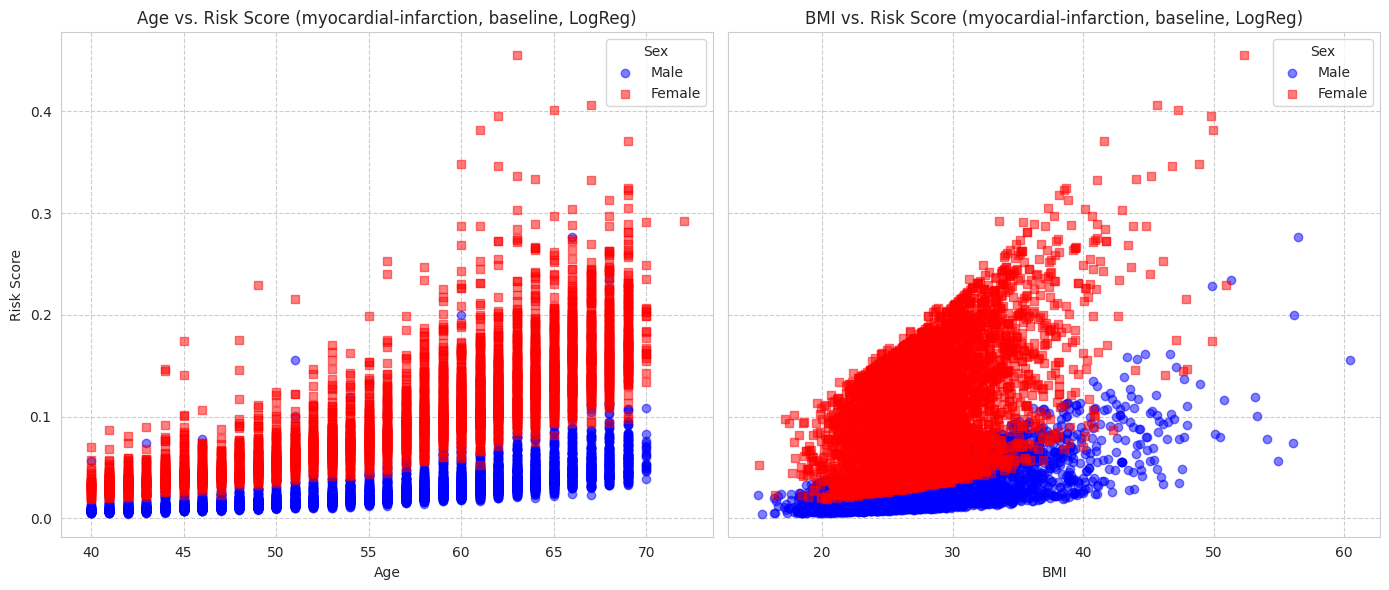

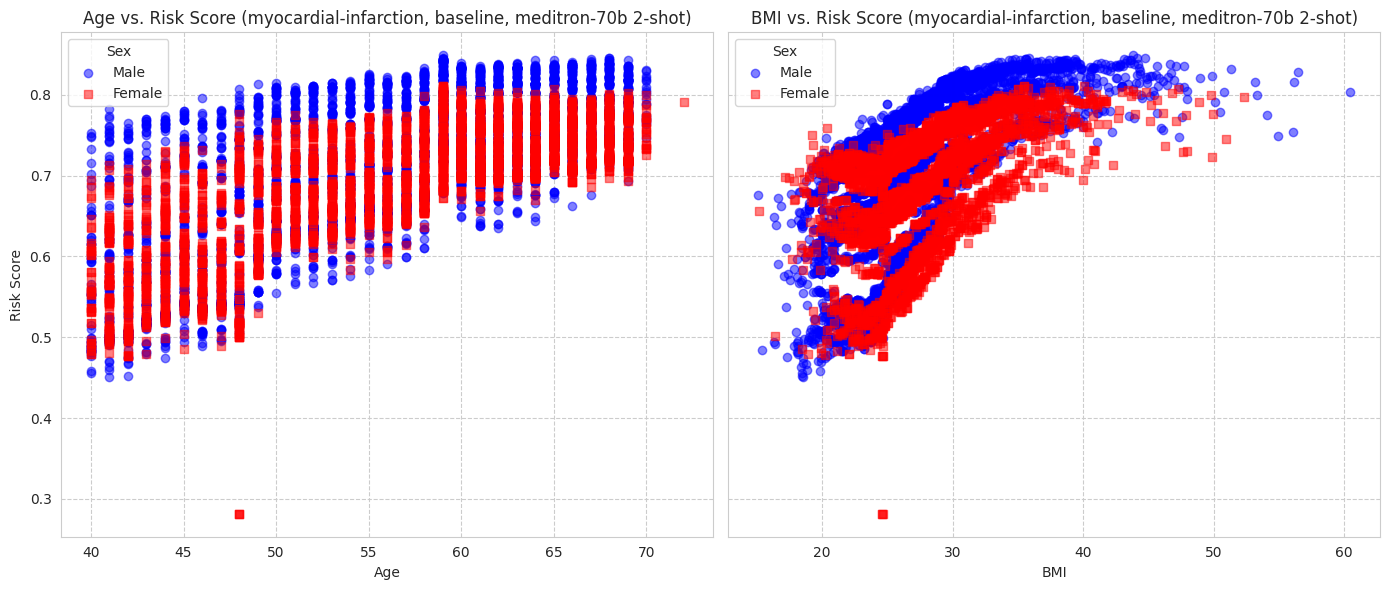

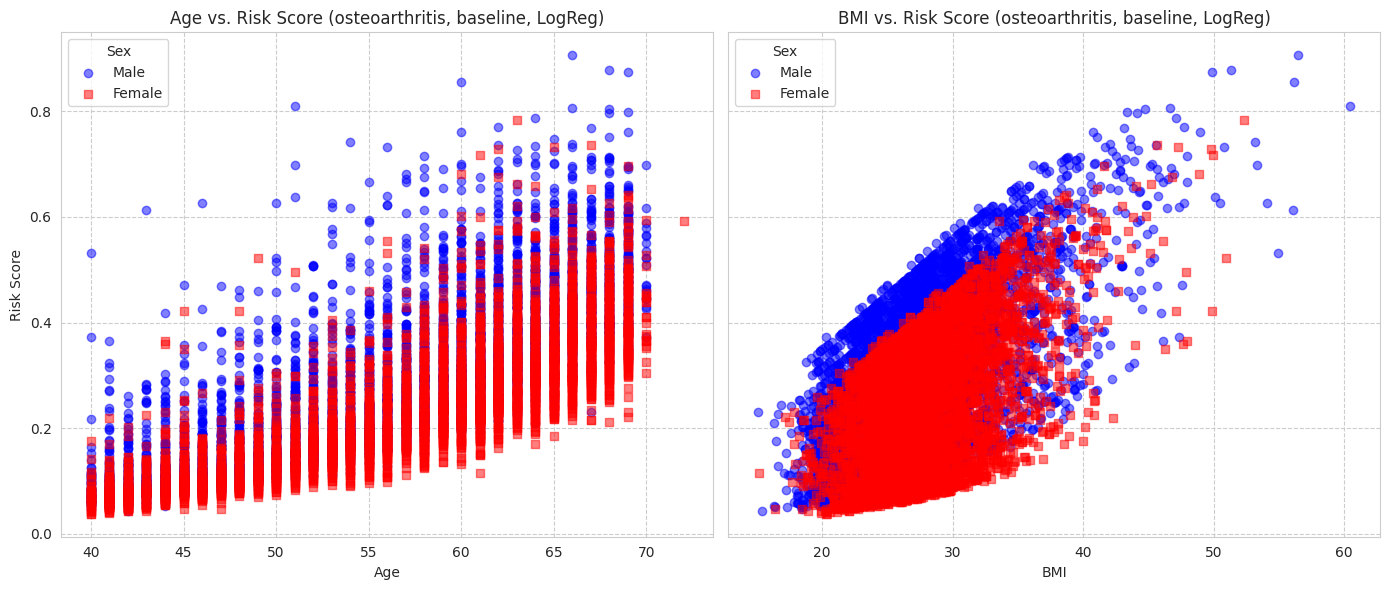

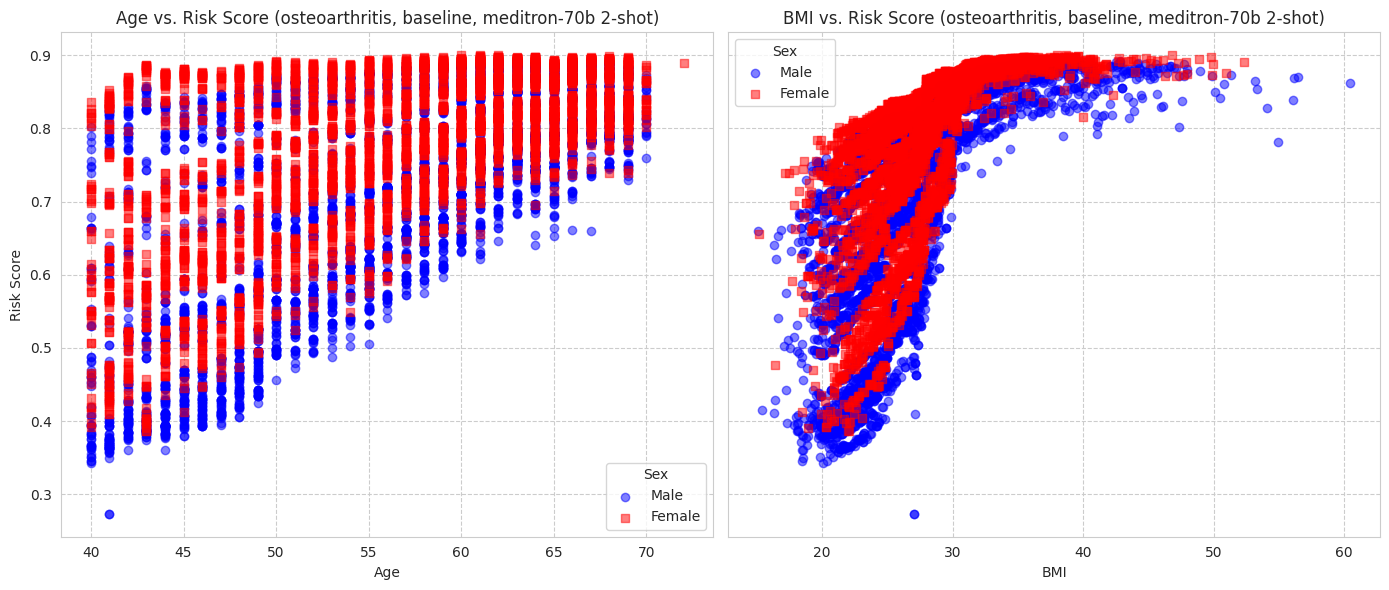

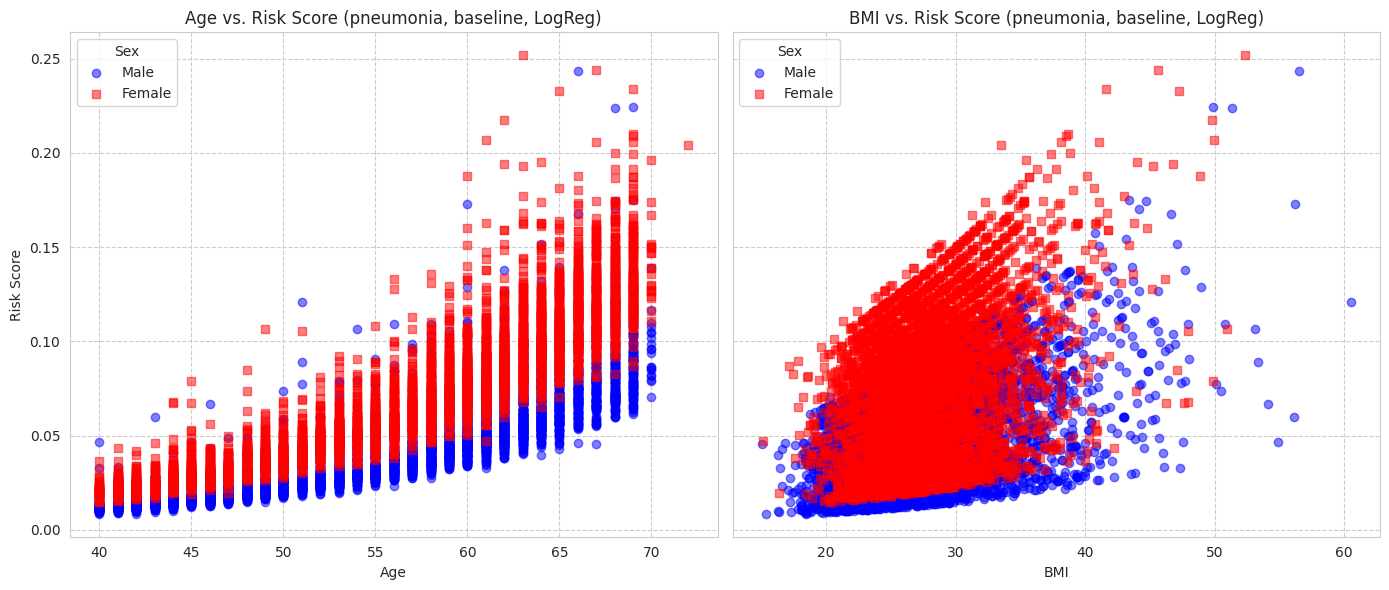

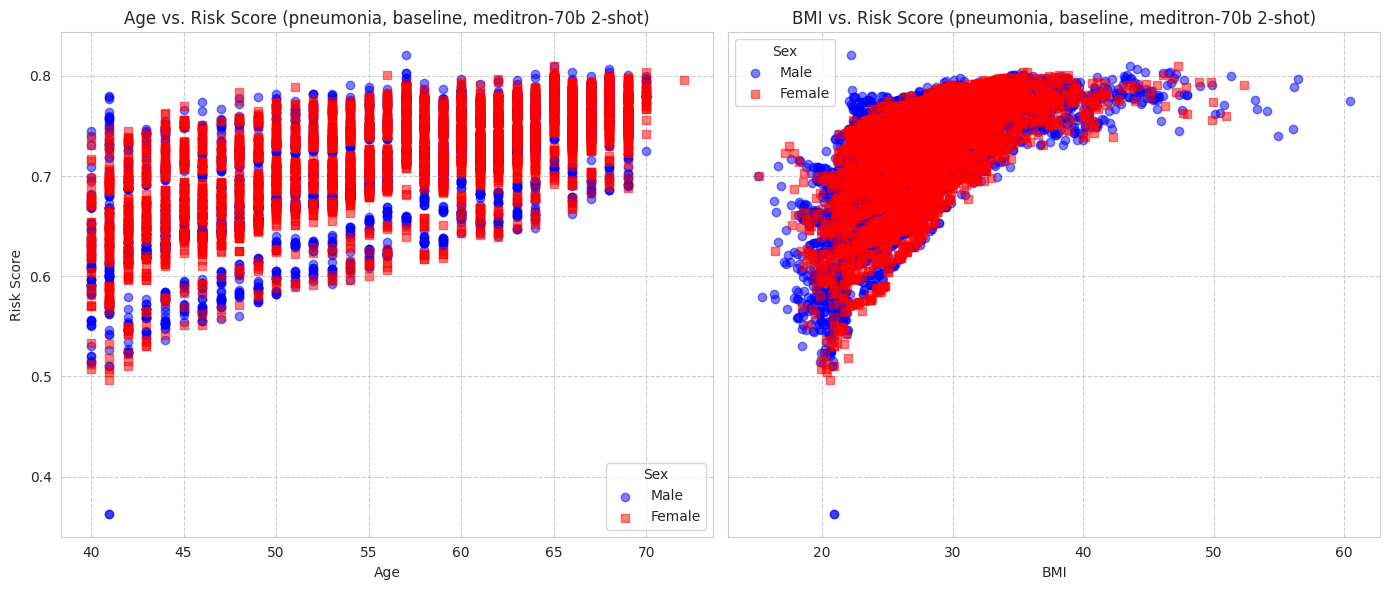

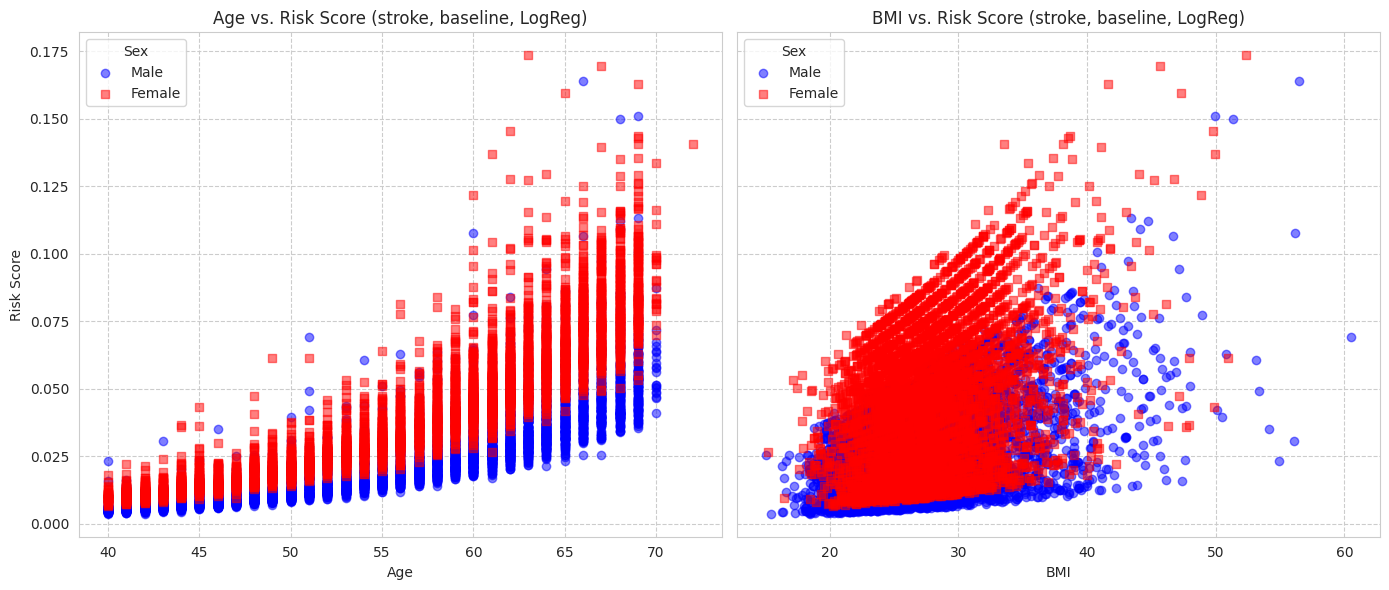

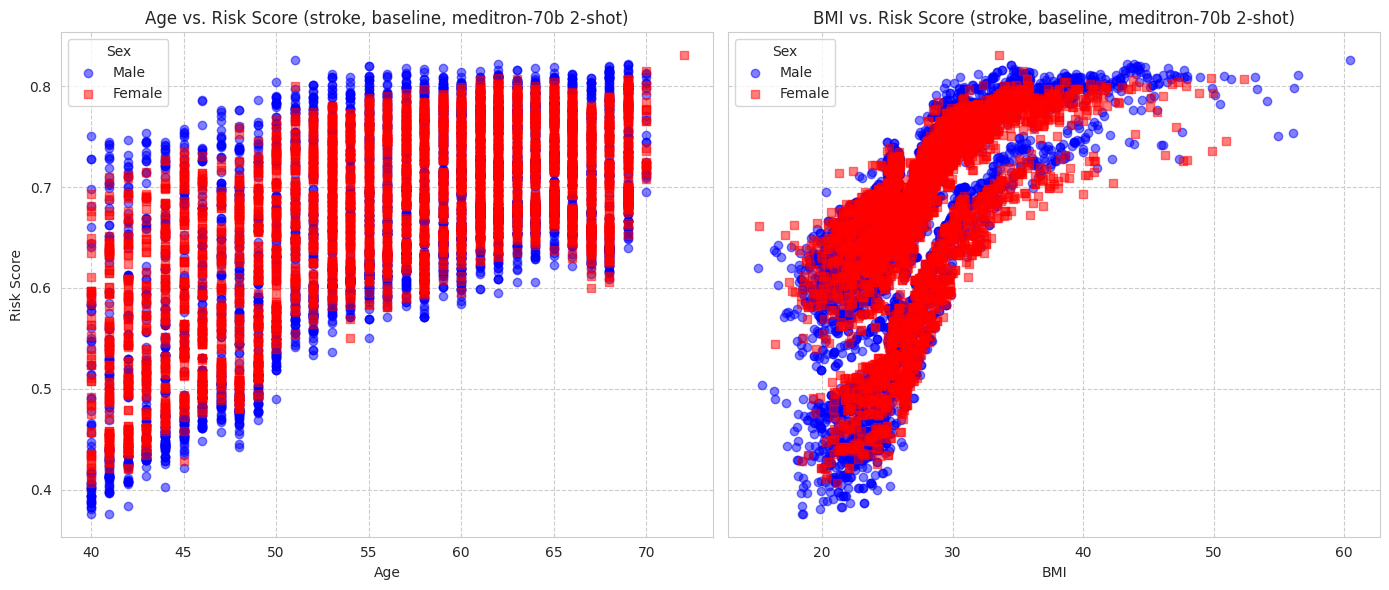

In [10]:
PHENOTYPES = [
    'asthma',
    'cataract',
    'diabetes',
    'gerd',
    'hay-fever-&-eczema',
    'major-depression',
    'myocardial-infarction',
    'osteoarthritis',
    'pneumonia',
    'stroke'
]
LLM_ID = 'epfl-llm/meditron-70b'
NB_SHOTS = 2
FEATURE_SET = 'baseline'

for phenotype in PHENOTYPES:
    # LogReg:
    log_reg_scores_path = f"../output/risk_scores/LogReg/rs_{phenotype}_{FEATURE_SET}.json"
    plot_age_bmi_vs_risk_score(log_reg_scores_path, df_val)
        
    # LLM:
    llm_scores_path = f"../hf_datasets/LLM-Disease-Risk-Scores/{LLM_ID}/rs_{phenotype}_{FEATURE_SET}_float16_{NB_SHOTS}-shots.json"
    plot_age_bmi_vs_risk_score(llm_scores_path, DF_VAL)